# CatBoost for Tabular Classification: How to run inference on the endpoint you have created?

## Import libraries

In [1]:
import json
import boto3
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## The test data to run on endpoint

In this section, you learn how to query an existing endpoint and make predictions of the examples you input. For each example, the model will output the probability of the sample for each class in the model. 
Next, the predicted class label is obtained by taking the class label with the maximum probability over others. Throughout the notebook, the examples are taken from the [MNIST](http://yann.lecun.com/exdb/mnist/) test set. 
The dataset contains examples of individual pixel values from each 28 x 28 grayscale image to predict the digit label of 10 classes {0, 1, 2, 3, ..., 9}.

Citations:

- [LeCun et al., 1998a] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. 'Gradient-based learning applied to document recognition.' Proceedings of the IEEE, 86(11):2278-2324, November 1998

In [3]:
# Download the data from s3 buckets
s3 = boto3.client("s3")
data_bucket = 'jumpstart-cache-prod-us-east-1'

data_path = "data.csv"

# downloading the test data from data_bucket
s3.download_file(data_bucket, 'training-datasets/tabular_multiclass/test/data.csv', data_path)

In [4]:
newline, bold, unbold = '\n', '\033[1m', '\033[0m'

# read the data
test_data = pd.read_csv(data_path, header=None)
test_data.columns = ['Target'] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print(f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n")

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"{bold}The first 5 observations of the data: {unbold} \n")
test_data.head(5)

The test dataset contains 10000 examples and 785 columns.

The first 5 observations of the data:  



,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_775,Feature_776,Feature_777,Feature_778,Feature_779,Feature_780,Feature_781,Feature_782,Feature_783,Feature_784
0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Query endpoint that you have created

The following code queries the endpoint you have created to get the prediction for each test example. 
The `query_endpoint()` function returns a array-like of shape (num_examples, num_classes), where each row indicates 
the probability of the example for each class in the model. The num_classes is 10 in above test data. 
Next, the predicted class label is obtained by taking the class label with the maximum probability over others for each example. 

In [8]:
content_type = "text/csv"
def query_endpoint(encoded_tabular_data):
    endpoint_name = "jumpstart-dft-cat-classification-mo-20250127-090008"
    client = boto3.client("runtime.sagemaker", region_name="us-east-1")
    # print(f"Sending batch of data to the endpoint {endpoint_name}", client)
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data)
    return response

def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = np.array(model_predictions['probabilities'])
    return predicted_probabilities

# split the test data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 1500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    try:
        query_response_batch = query_endpoint(features.iloc[i:(i+batch_size), :].to_csv(header=False, index=False).encode("utf-8"))
    except Exception as e:
        if e.response is not None and 'Error' in e.response and e.response.get('Error').get('Code') == 'ModelError':
            raise Exception(
                 "Backend scripts have been updated in February '22 to standardize response "
                 "format of endpoint response."
                 "Previous endpoints may not support verbose response type used in this notebook."
                 f"To use this notebook, please launch the endpoint again. Error: {e}."
            )
        else:
            raise
    try:
        predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    except (TypeError, KeyError) as e:
        raise Exception(
              "Backend scripts have been updated in February '22 to standardize response "
              "format of endpoint response."
               "Response from previous endpoints may not be consistent with this notebook."
               f"To use this notebook, please launch the endpoint again. Error: {e}."
       )
    predict_prob.append(predict_prob_batch)


predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(predict_prob, axis=1)

## Evaluate the predictions results returned from the endpoint

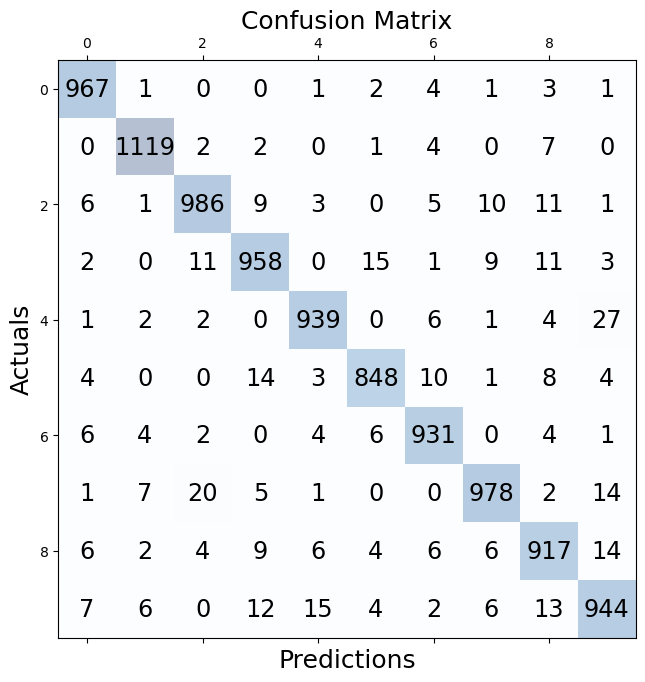

In [17]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [9]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1_macro = f1_score(ground_truth_label.values, predict_label, average="macro")
eval_f1_micro = f1_score(ground_truth_label.values, predict_label, average="micro")

print (
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{accuracy_score.__name__}{unbold}: {eval_accuracy}{newline}"
    f"{bold}F1 Macro{unbold}: {eval_f1_macro}{newline}"
    f"{bold}F1 Micro{unbold}: {eval_f1_micro}{newline}"
)

Evaluation result on test data:
accuracy_score: 0.9587
F1 Macro: 0.9583846671811884
F1 Micro: 0.9587

